In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import seaborn as sn
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree._tree import TREE_LEAF
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
def get_corr_matrix(df):
    corrMatrix = df.corr()
    plt.figure(figsize=(20, 10))
    sn.heatmap(corrMatrix, xticklabels=corrMatrix.columns, yticklabels=corrMatrix.columns, annot=True)
    plt.show()

In [116]:
def print_result(y_real, y_predicted):
    cm = confusion_matrix(y_real, y_predicted) 
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, fmt="g", ax=ax)

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["not_churn", "churn"])
    ax.yaxis.set_ticklabels(["not_churn", "churn"])

    print(classification_report(y_real, y_predicted))
    print("Accuracy is ", accuracy_score(y_real, y_predicted))
    print("F1 Score is ", f1_score(y_real, y_predicted, average="macro"))
    print("Precision is ", precision_score(y_real, y_predicted, average="macro"))
    print("Recall is ", recall_score(y_real, y_predicted, average="macro"))


In [4]:
df = pd.read_csv("Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Veri Kümesindeki Özelliklerin Anlamı
1. **customer_id :** Müşteri numarası
2. **credit_score :** Müşterinin bireysel kredi skoru
3. **country :** Müşterinin yaşadığı ülke
4. **gender :** Müşterinin cinsiyeti
5. **age :** Müşterinin yaşı
6. **tenure :** Müşterinin bankada hesabının kaç yıldır olduğu bilgisi
7. **balance :** Müşterinin hesabında bulunan tutar
8. **products_number :** Müşterinin sahip olduğu ürün sayısı
9. **credit_card :** Müşterinin kredi kartının olup/olmadığı bilgisi
10. **active_member :** Müşterinin hesabının aktif olup/olmama bilgisi
11. **estimated_salary :** Müşterinin tahmini maaşı
12. **churn :** Müşterinin banka müşteriliğinden ayrılıp/ayrılmama bilgisi


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
df.gender = df.gender.map({"Male":1, "Female":0})
df[["france", "germany", "spain"]] = pd.get_dummies(df.country)
df = df[["credit_score", "gender", "age", "tenure", "balance", "products_number",
       "credit_card", "active_member", "estimated_salary", "france",
       "germany", "spain" , "churn"]]

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
gender,10000.0,0.545700,0.497932,0.00,0.00,1.000,1.0000,1.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
products_number,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
credit_card,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
active_member,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
france,10000.0,0.501400,0.500023,0.00,0.00,1.000,1.0000,1.00


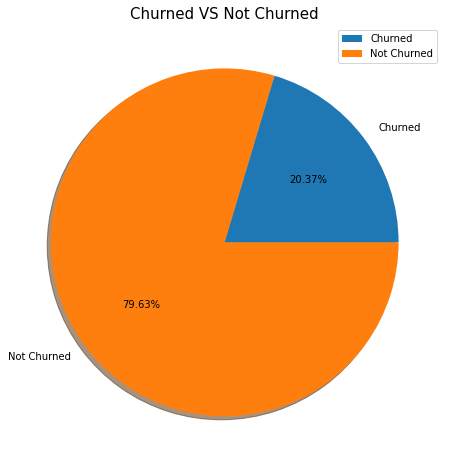

In [8]:
labels = ["Churned", "Not Churned"]
figure, axes = plt.subplots(figsize=(10, 8))
axes.pie([df[df.churn == 1].size, df[df.churn == 0].size], labels=labels, shadow=True, autopct = "%1.2f%%")
plt.legend()
plt.title("Churned VS Not Churned", size = 15)
plt.show()

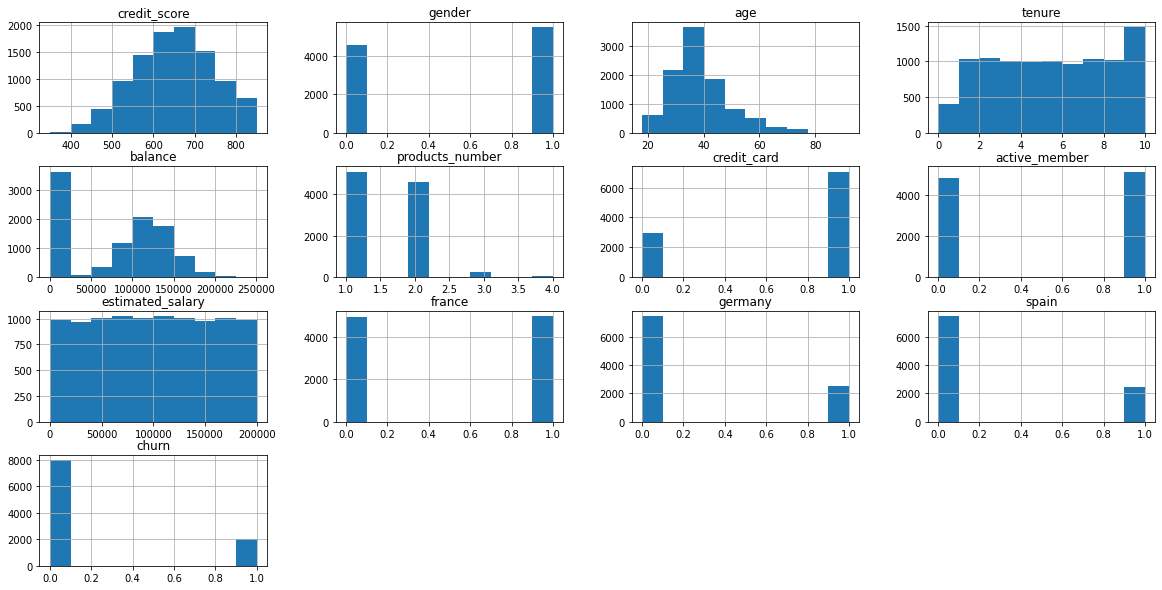

In [9]:
df.hist(figsize = (20,10))
plt.show()

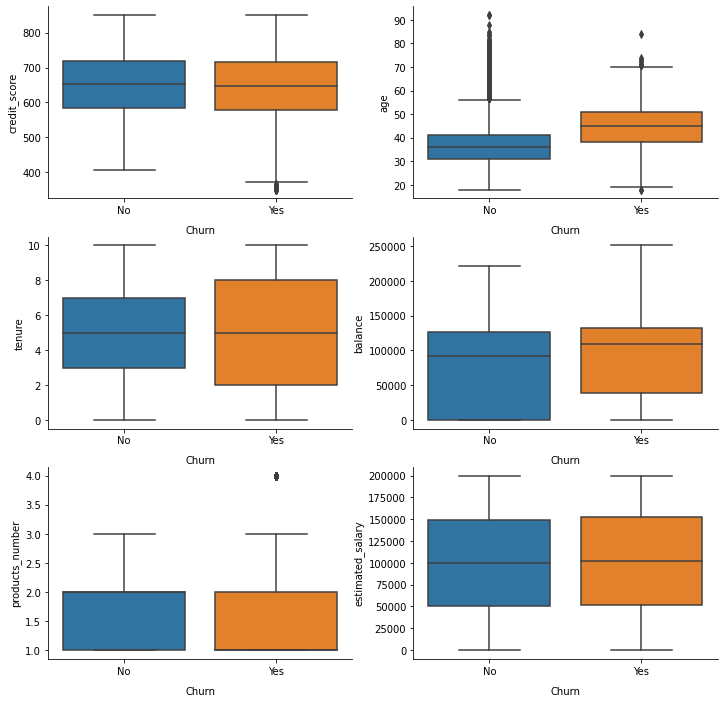

In [10]:
numerical_labels = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary"]
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
k = 0
for i in range(3):
    for j in range(2):
        ax1 = sn.boxplot(x="churn", y=numerical_labels[k], data=df, ax=ax[i][j])
        ax1.set_xlabel("Churn", labelpad=10)
        ax1.set_xticklabels(["No", "Yes"])
        k+=1
sn.despine()

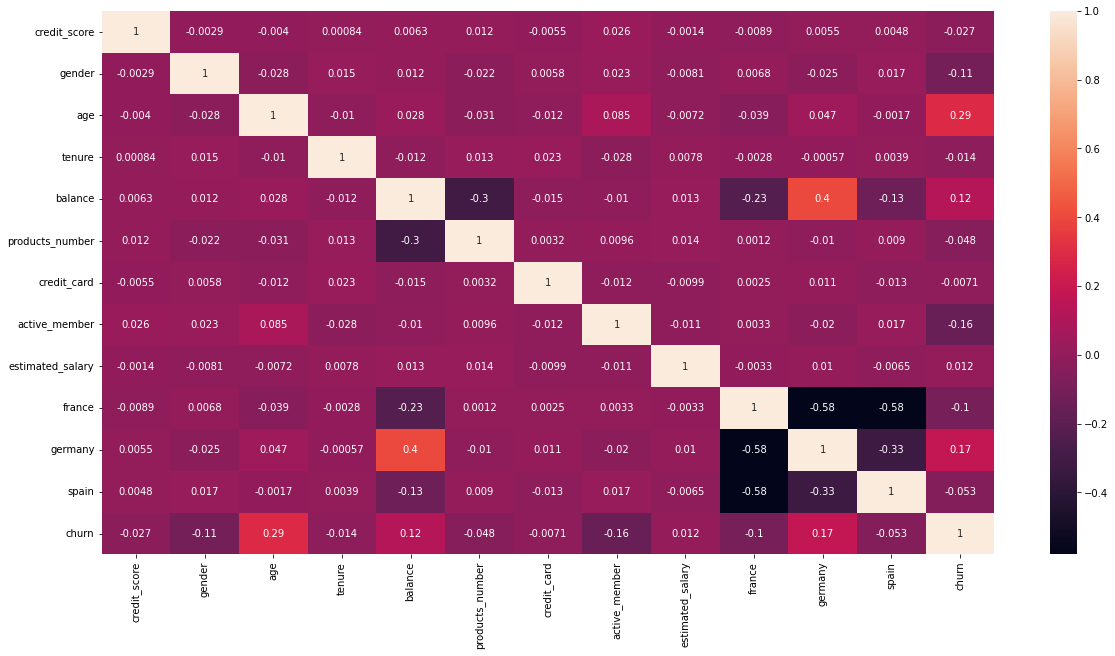

In [11]:
get_corr_matrix(df)

In [12]:
train, test = train_test_split(df, train_size=700, test_size=300, random_state=42, stratify=df.churn)
train, validation = train_test_split(train, train_size=400, test_size=300, random_state=42, stratify=train.churn)

X_train = train.iloc[:, :-1]
y_train = train.churn
X_validation = validation.iloc[:, :-1]
y_validation = validation.churn
X_test = test.iloc[:, :-1]
y_test = test.churn

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       239
           1       0.35      0.23      0.28        61

    accuracy                           0.76       300
   macro avg       0.58      0.56      0.57       300
weighted avg       0.72      0.76      0.74       300

Accuracy is  0.7566666666666667
F1 Score is  0.5654675688009683
Precision is  0.5846153846153845
Recall is  0.5603607929213252


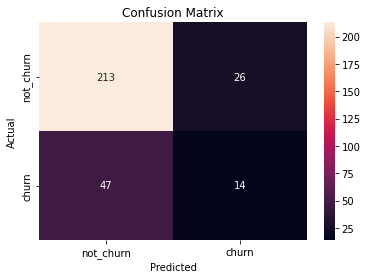

In [118]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print_result(y_test, y_pred_nb)

In [119]:
params = {"alpha": [a*0.1 for a in range(0,11)]}

grid = GridSearchCV(estimator=nb, param_grid=params,
                    cv=10, scoring="f1_micro", return_train_score=False, verbose=0, n_jobs=-1)
grid.fit(X_validation, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.30000000000000004}
0.7633333333333334


              precision    recall  f1-score   support

           0       0.82      0.89      0.85       239
           1       0.35      0.23      0.28        61

    accuracy                           0.76       300
   macro avg       0.58      0.56      0.57       300
weighted avg       0.72      0.76      0.74       300

Accuracy is  0.7566666666666667
F1 Score is  0.5654675688009683
Precision is  0.5846153846153845
Recall is  0.5603607929213252


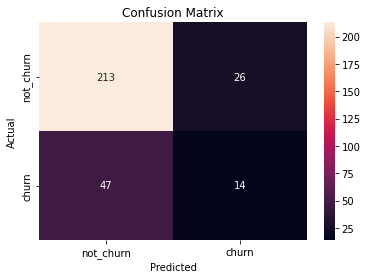

In [120]:
nb = BernoulliNB(**grid.best_params_)
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print_result(y_test, y_pred_nb)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       239
           1       0.50      0.52      0.51        61

    accuracy                           0.80       300
   macro avg       0.69      0.70      0.69       300
weighted avg       0.80      0.80      0.80       300

Accuracy is  0.7966666666666666
F1 Score is  0.6917894736842105
Precision is  0.6885593220338984
Recall is  0.6953494752726525


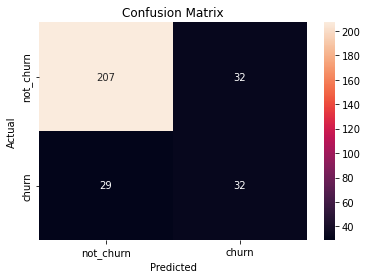

In [121]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

In [122]:
params = {"max_features": ["auto", "sqrt", "log2"],
          "ccp_alpha": [0.1, .01, .001],
          "max_depth": [5, 6, 7, 8, 9, 10, 11, 12],
          "min_samples_split": [2, 3, 4],
          "min_samples_leaf": [1, 2],
          "criterion": ["gini", "entropy"]
          }
grid = GridSearchCV(estimator=dt, param_grid=params,
                    cv=10, scoring="f1", return_train_score=False, verbose=0, n_jobs=-1)
grid.fit(X_validation, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4}
0.4423853923853923


              precision    recall  f1-score   support

           0       0.83      0.94      0.88       239
           1       0.53      0.26      0.35        61

    accuracy                           0.80       300
   macro avg       0.68      0.60      0.62       300
weighted avg       0.77      0.80      0.78       300

Accuracy is  0.8033333333333333
F1 Score is  0.6178673978281051
Precision is  0.6833333333333333
Recall is  0.6018588380547363


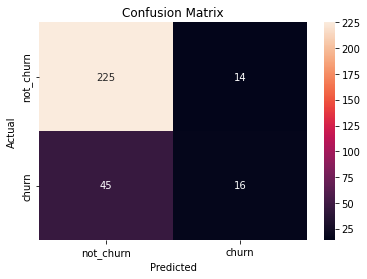

In [123]:
dt = DecisionTreeClassifier(**grid.best_params_, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

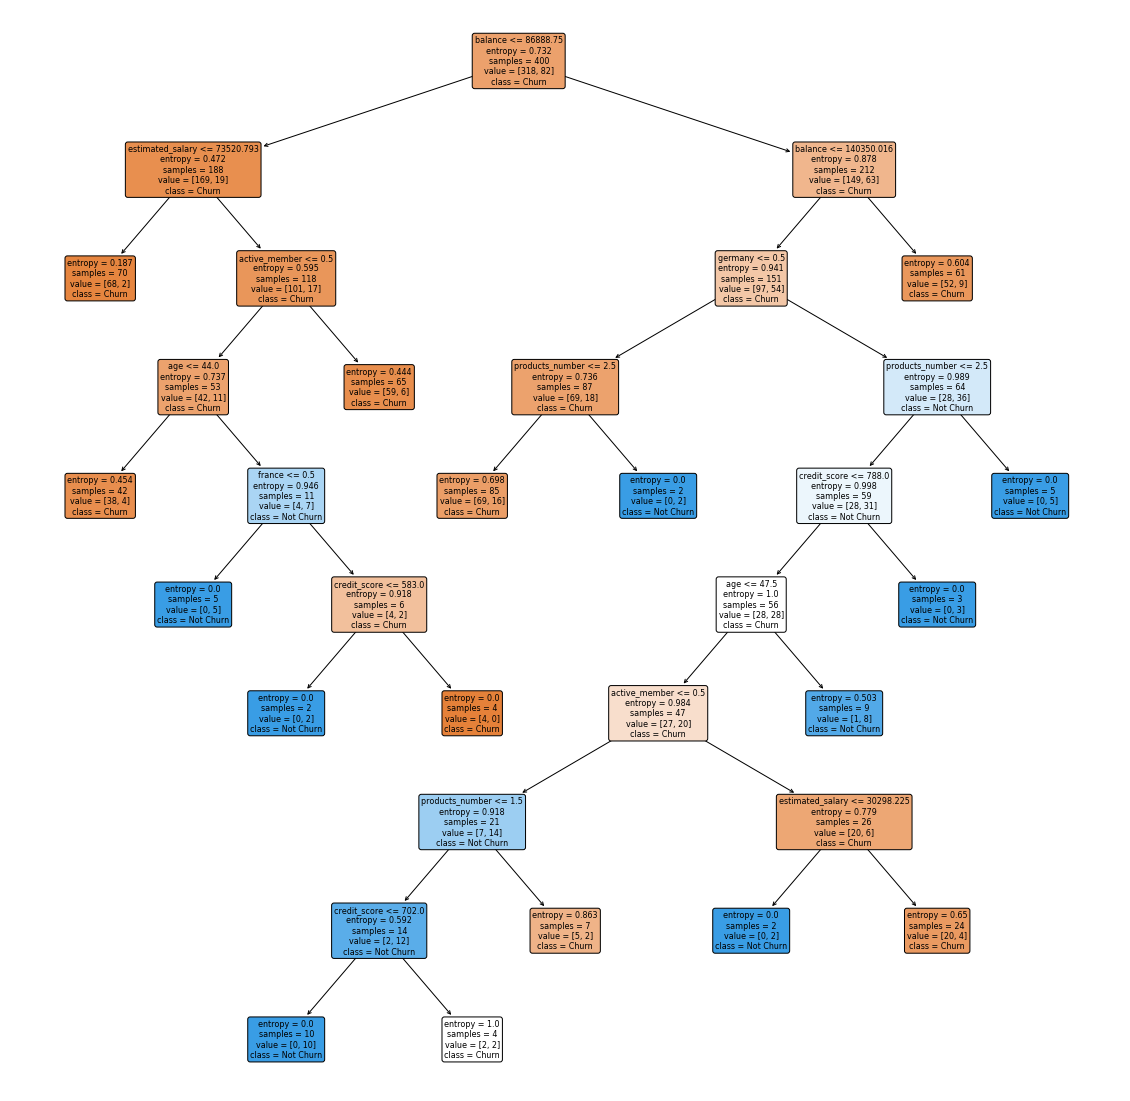

In [124]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_tree(dt, 
          feature_names = df.columns[:-1], 
          class_names = ["Churn", "Not Churn"], 
          filled = True, 
          rounded = True,
          ax=ax,
          fontsize=8)

plt.savefig("tree_visualization.png") 
plt.show()

In [125]:
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

print(sum(dt.tree_.children_left < 0))
prune_index(dt.tree_, 0, 5)
sum(dt.tree_.children_left < 0)

17


19

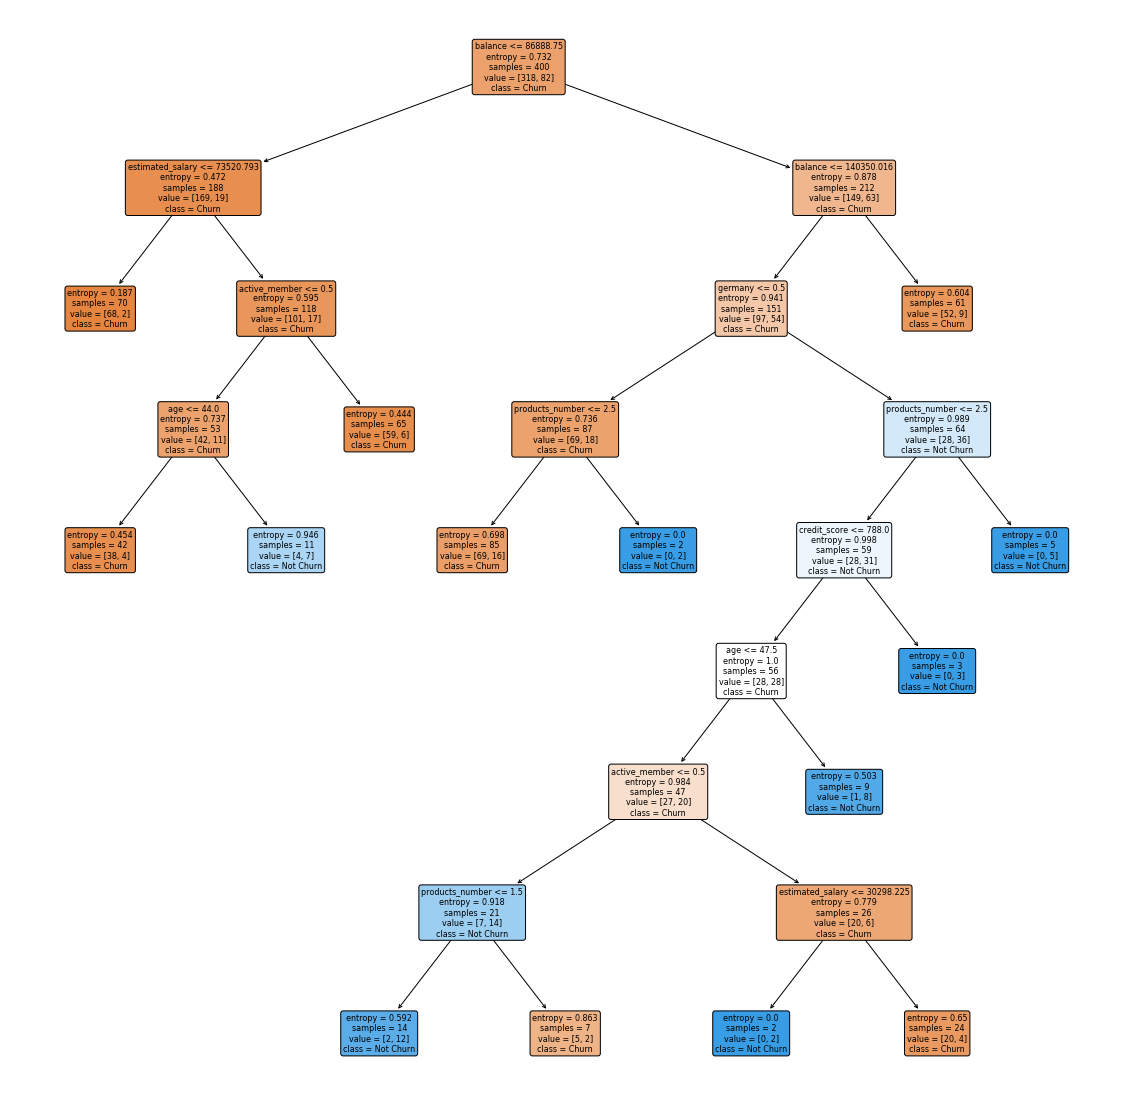

In [126]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_tree(dt, 
          feature_names = df.columns[:-1], 
          class_names = ["Churn", "Not Churn"], 
          filled = True, 
          rounded = True,
          ax=ax,
          fontsize=8)

plt.savefig("tree_visualization2.png") 
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       239
           1       0.53      0.31      0.39        61

    accuracy                           0.80       300
   macro avg       0.68      0.62      0.64       300
weighted avg       0.78      0.80      0.78       300

Accuracy is  0.8033333333333333
F1 Score is  0.6372281773277858
Precision is  0.6843434343434344
Recall is  0.6201728513615474


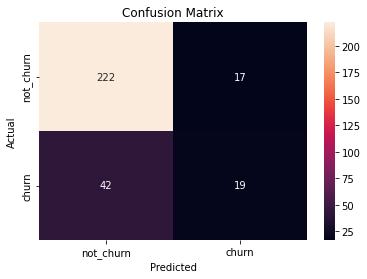

In [127]:
y_pred_dt = dt.predict(X_test)
print_result(y_test, y_pred_dt)

In [128]:
scaler = StandardScaler()

X_train_standardized = scaler.fit_transform(X_train)
X_validation_standardized = scaler.fit_transform(X_validation)
X_test_standardized = scaler.fit_transform(X_test)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       239
           1       0.56      0.25      0.34        61

    accuracy                           0.81       300
   macro avg       0.69      0.60      0.61       300
weighted avg       0.78      0.81      0.78       300

Accuracy is  0.8066666666666666
F1 Score is  0.6138139204545455
Precision is  0.6935286935286935
Recall is  0.5978462171616709


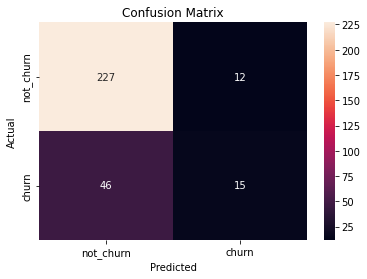

In [129]:
knn = KNeighborsClassifier()
knn.fit(X_train_standardized, y_train)
y_pred_knn = knn.predict(X_test_standardized)
print_result(y_test, y_pred_knn)

In [130]:
params = {"n_neighbors": [1, 3, 5, 7, 9, 11]}
grid = GridSearchCV(estimator=knn,
                    param_grid=params,
                    cv=10,
                    scoring="f1", return_train_score=False, verbose=0, n_jobs=-1)
grid.fit(X_validation_standardized, y_validation)
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 3}
0.29473304473304474


              precision    recall  f1-score   support

           0       0.83      0.92      0.88       239
           1       0.49      0.28      0.35        61

    accuracy                           0.79       300
   macro avg       0.66      0.60      0.62       300
weighted avg       0.76      0.79      0.77       300

Accuracy is  0.7933333333333333
F1 Score is  0.6155753968253969
Precision is  0.6598382749326146
Recall is  0.6016873585293916


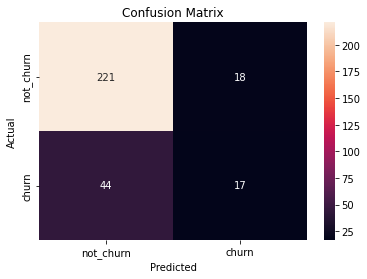

In [131]:
knn = KNeighborsClassifier(**grid.best_params_)
knn.fit(X_train_standardized, y_train)
y_pred_knn = knn.predict(X_test_standardized)
print_result(y_test, y_pred_knn)

In [132]:
def create_model(activation = "sigmoid", hidden_layers=1):
  model = Sequential()
  model.add(Dense(12, activation=activation, input_shape=(12,)))

  for i in range(hidden_layers):
    model.add(Dense(36, activation=activation))

  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

In [133]:
my_classifier = KerasClassifier(build_fn=create_model, verbose=1)
hyperparameters = dict(
    epochs=[50, 100],
    batch_size=[16, 32, 64],
    hidden_layers=[1, 2, 3],
    activation=["relu", "sigmoid"],
)

grid = GridSearchCV(estimator=my_classifier,
                    param_grid=hyperparameters,
                    cv=10,
                    scoring="f1", 
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_validation_standardized, y_validation)
print(grid.best_params_)
print(grid.best_score_)

C:\Users\furka\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Fitting 10 folds for each of 36 candidates, totalling 360 fits


c:\Users\furka\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\externals\loky\process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/100
10/10 [==============================] - 2s 5ms/step - loss: 0.6389 - accuracy: 0.7167
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.5707 - accuracy: 0.7967
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5374 - accuracy: 0.7967
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5184 - accuracy: 0.7967
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5071 - accuracy: 0.7967
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 0.4938 - accuracy: 0.7967
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.7967
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7967
Epoch 9/100
10/10 [==============================] - 0s 3ms/step - loss: 0.4645 - accuracy: 0.7967
Epoch 10/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4561 - accuracy: 0.7967
Epoch 11/

Epoch 1/50
13/13 [==============================] - 1s 2ms/step - loss: 0.6301 - accuracy: 0.7775
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 0.5491 - accuracy: 0.7950
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7950
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.7950
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7950
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4737 - accuracy: 0.7950
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7950
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.7950
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7950
Epoch 10/50
13/13 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.7950
Epoch 11/50
13/13 [

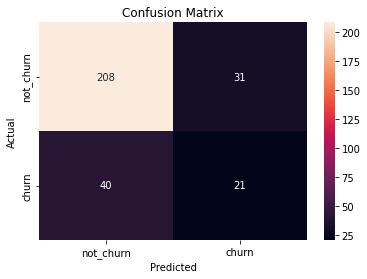

In [134]:
model = create_model("relu", 3)
model.fit(X_train_standardized, y_train, epochs=50, batch_size=32)
y_pred_ann = []
for element in model.predict(X_test_standardized):
    if element > 0.5:
        y_pred_ann.append(1)
    else:
        y_pred_ann.append(0)
print_result(y_test, y_pred_ann)